In [1]:
from os import listdir
from os.path import isdir, join
import librosa
import random
import numpy as np
import matplotlib.pyplot as plt
import python_speech_features

In [2]:
# Dataset path and view possible targets
dataset_path = './speech_command_dataset'
for name in listdir(dataset_path):
    if isdir(join(dataset_path, name)):
        print(name)

_background_noise_
nine
happy
tree
backward
bed
learn
one
five
Images
off
down
forward
sheila
cat
dog
up
bird
follow
six
eight
zero
three
right
go
left
no
wow
stop
on
yes
four
visual
marvin
seven
two
house


In [3]:
# Create an all targets list
all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
print(all_targets)

['_background_noise_', 'nine', 'happy', 'tree', 'backward', 'bed', 'learn', 'one', 'five', 'Images', 'off', 'down', 'forward', 'sheila', 'cat', 'dog', 'up', 'bird', 'follow', 'six', 'eight', 'zero', 'three', 'right', 'go', 'left', 'no', 'wow', 'stop', 'on', 'yes', 'four', 'visual', 'marvin', 'seven', 'two', 'house']


In [4]:
# Leave off background noise set
all_targets.remove('_background_noise_')
print(all_targets)

['nine', 'happy', 'tree', 'backward', 'bed', 'learn', 'one', 'five', 'Images', 'off', 'down', 'forward', 'sheila', 'cat', 'dog', 'up', 'bird', 'follow', 'six', 'eight', 'zero', 'three', 'right', 'go', 'left', 'no', 'wow', 'stop', 'on', 'yes', 'four', 'visual', 'marvin', 'seven', 'two', 'house']


In [5]:
# See how many files are in each
num_samples = 0
for target in all_targets:
    print(len(listdir(join(dataset_path, target))))
    num_samples += len(listdir(join(dataset_path, target)))
print('Total samples:', num_samples)

3934
2054
1759
1664
2014
1575
3890
4052
2
3745
3917
1557
2022
2031
2128
3723
2064
1579
3860
3787
4052
3727
3778
3880
3801
3941
2123
3872
3845
4044
3728
1592
2100
3998
3880
2113
Total samples: 105831


In [6]:
# Settings
target_list = all_targets
feature_sets_file = 'all_targets_mfcc_sets.npz'
perc_keep_samples = 1.0 # 1.0 is keep all samples
val_ratio = 0.1
test_ratio = 0.1
sample_rate = 8000
num_mfcc = 16
len_mfcc = 16

In [7]:
# Create list of filenames along with ground truth vector (y)
filenames = []
y = []
for index, target in enumerate(target_list):
    print(join(dataset_path, target))
    filenames.append(listdir(join(dataset_path, target)))
    y.append(np.ones(len(filenames[index])) * index)

./speech_command_dataset/nine
./speech_command_dataset/happy
./speech_command_dataset/tree
./speech_command_dataset/backward
./speech_command_dataset/bed
./speech_command_dataset/learn
./speech_command_dataset/one
./speech_command_dataset/five
./speech_command_dataset/Images
./speech_command_dataset/off
./speech_command_dataset/down
./speech_command_dataset/forward
./speech_command_dataset/sheila
./speech_command_dataset/cat
./speech_command_dataset/dog
./speech_command_dataset/up
./speech_command_dataset/bird
./speech_command_dataset/follow
./speech_command_dataset/six
./speech_command_dataset/eight
./speech_command_dataset/zero
./speech_command_dataset/three
./speech_command_dataset/right
./speech_command_dataset/go
./speech_command_dataset/left
./speech_command_dataset/no
./speech_command_dataset/wow
./speech_command_dataset/stop
./speech_command_dataset/on
./speech_command_dataset/yes
./speech_command_dataset/four
./speech_command_dataset/visual
./speech_command_dataset/marvin
./sp

In [8]:
# Check ground truth Y vector
print(y)
for item in y:
    print(len(item))

[array([0., 0., 0., ..., 0., 0., 0.]), array([1., 1., 1., ..., 1., 1., 1.]), array([2., 2., 2., ..., 2., 2., 2.]), array([3., 3., 3., ..., 3., 3., 3.]), array([4., 4., 4., ..., 4., 4., 4.]), array([5., 5., 5., ..., 5., 5., 5.]), array([6., 6., 6., ..., 6., 6., 6.]), array([7., 7., 7., ..., 7., 7., 7.]), array([8., 8.]), array([9., 9., 9., ..., 9., 9., 9.]), array([10., 10., 10., ..., 10., 10., 10.]), array([11., 11., 11., ..., 11., 11., 11.]), array([12., 12., 12., ..., 12., 12., 12.]), array([13., 13., 13., ..., 13., 13., 13.]), array([14., 14., 14., ..., 14., 14., 14.]), array([15., 15., 15., ..., 15., 15., 15.]), array([16., 16., 16., ..., 16., 16., 16.]), array([17., 17., 17., ..., 17., 17., 17.]), array([18., 18., 18., ..., 18., 18., 18.]), array([19., 19., 19., ..., 19., 19., 19.]), array([20., 20., 20., ..., 20., 20., 20.]), array([21., 21., 21., ..., 21., 21., 21.]), array([22., 22., 22., ..., 22., 22., 22.]), array([23., 23., 23., ..., 23., 23., 23.]), array([24., 24., 24., ..

In [9]:
# Flatten filename and y vectors
filenames = [item for sublist in filenames for item in sublist]
y = [item for sublist in y for item in sublist]

In [10]:
# Associate filenames with true output and shuffle
filenames_y = list(zip(filenames, y))
random.shuffle(filenames_y)
filenames, y = zip(*filenames_y)

In [11]:
# Only keep the specified number of samples (shorter extraction/training)
print(len(filenames))
filenames = filenames[:int(len(filenames) * perc_keep_samples)]
print(len(filenames))

105831
105831


In [12]:
# Calculate validation and test set sizes
val_set_size = int(len(filenames) * val_ratio)
test_set_size = int(len(filenames) * test_ratio)

In [13]:
# Break dataset apart into train, validation, and test sets
filenames_val = filenames[:val_set_size]
filenames_test = filenames[val_set_size:(val_set_size + test_set_size)]
filenames_train = filenames[(val_set_size + test_set_size):]

In [14]:
# Break y apart into train, validation, and test sets
y_orig_val = y[:val_set_size]
y_orig_test = y[val_set_size:(val_set_size + test_set_size)]
y_orig_train = y[(val_set_size + test_set_size):]

In [15]:
# Function: Create MFCC from given path
def calc_mfcc(path):
    
    # Load wavefile
    signal, fs = librosa.load(path, sr=sample_rate)
    
    # Create MFCCs from sound clip
    mfccs = python_speech_features.base.mfcc(signal, 
                                            samplerate=fs,
                                            winlen=0.256,
                                            winstep=0.050,
                                            numcep=num_mfcc,
                                            nfilt=26,
                                            nfft=2048,
                                            preemph=0.0,
                                            ceplifter=0,
                                            appendEnergy=False,
                                            winfunc=np.hanning)
    return mfccs.transpose()

In [16]:
# TEST: Construct test set by computing MFCC of each WAV file
prob_cnt = 0
x_test = []
y_test = []
for index, filename in enumerate(filenames_train):
    
    # Stop after 500
    if index >= 500:
        break
    
    # Create path from given filename and target item
    path = join(dataset_path, target_list[int(y_orig_train[index])], 
                filename)
    
    # Create MFCCs
    mfccs = calc_mfcc(path)
    
    if mfccs.shape[1] == len_mfcc:
        x_test.append(mfccs)
        y_test.append(y_orig_train[index])
    else:
        print('Dropped:', index, mfccs.shape)
        prob_cnt += 1
        

Dropped: 0 (16, 15)
Dropped: 15 (16, 14)
Dropped: 18 (16, 13)
Dropped: 21 (16, 15)
Dropped: 54 (16, 11)
Dropped: 59 (16, 12)
Dropped: 74 (16, 13)
Dropped: 104 (16, 13)
Dropped: 115 (16, 13)
Dropped: 164 (16, 11)
Dropped: 182 (16, 10)
Dropped: 191 (16, 10)
Dropped: 198 (16, 10)
Dropped: 213 (16, 13)
Dropped: 216 (16, 11)
Dropped: 228 (16, 9)
Dropped: 259 (16, 8)
Dropped: 284 (16, 14)
Dropped: 286 (16, 13)
Dropped: 299 (16, 10)
Dropped: 317 (16, 11)
Dropped: 323 (16, 12)
Dropped: 330 (16, 15)
Dropped: 358 (16, 13)
Dropped: 361 (16, 11)
Dropped: 374 (16, 12)
Dropped: 381 (16, 11)
Dropped: 390 (16, 15)
Dropped: 392 (16, 9)
Dropped: 422 (16, 12)
Dropped: 460 (16, 14)
Dropped: 478 (16, 9)
Dropped: 495 (16, 11)


In [17]:
print('% of problematic samples:', prob_cnt / 500)

% of problematic samples: 0.066


Defaulting to user installation because normal site-packages is not writeable
MFCCs: [[-3.31570125e+01 -3.35448898e+01 -3.40238034e+01 -3.37647121e+01
  -3.34005691e+01 -3.29730599e+01 -2.88124625e+01 -2.49485536e+01
  -2.31564704e+01 -2.23222368e+01 -2.21442189e+01 -2.30320932e+01
  -2.57625160e+01 -2.93019132e+01 -3.15965538e+01 -3.20320060e+01]
 [ 7.71459329e+00  7.58010769e+00  7.51144842e+00  7.82584128e+00
   7.98534103e+00  7.59290536e+00  9.42775341e+00  1.13393550e+01
   1.21960345e+01  1.23191086e+01  1.22074885e+01  1.16327971e+01
   1.02202014e+01  8.49466577e+00  7.06165355e+00  6.74926602e+00]
 [-1.25211332e+00 -1.22591280e+00 -8.49422958e-01 -7.70247556e-01
  -8.15555343e-01 -1.07461740e+00 -2.84233889e+00 -4.01656537e+00
  -4.33228227e+00 -4.47505298e+00 -4.78157680e+00 -4.07948347e+00
  -2.68587499e+00 -1.63924723e+00 -1.00514636e+00 -1.00722555e+00]
 [-1.16703061e+00 -1.06560694e+00 -1.14773996e+00 -1.47232989e+00
  -1.07781605e+00 -9.01407918e-01 -2.77966074e+00 -3.7

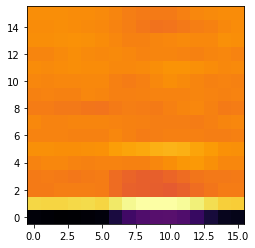

In [18]:
# TEST: Test shorter MFCC
!pip install playsound
from playsound import playsound

idx = 13

# Create path from given filename and target item
path = join(dataset_path, target_list[int(y_orig_train[idx])], 
            filenames_train[idx])

# Create MFCCs
mfccs = calc_mfcc(path)
print("MFCCs:", mfccs)

# Plot MFCC
fig = plt.figure()
plt.imshow(mfccs, cmap='inferno', origin='lower')

# TEST: Play problem sounds
print(target_list[int(y_orig_train[idx])])
playsound(path)

In [19]:
# Function: Create MFCCs, keeping only ones of desired length
def extract_features(in_files, in_y):
    prob_cnt = 0
    out_x = []
    out_y = []
        
    for index, filename in enumerate(in_files):
    
        # Create path from given filename and target item
        path = join(dataset_path, target_list[int(in_y[index])], 
                    filename)
        
        # Check to make sure we're reading a .wav file
        if not path.endswith('.wav'):
            continue

        # Create MFCCs
        mfccs = calc_mfcc(path)

        # Only keep MFCCs with given length
        if mfccs.shape[1] == len_mfcc:
            out_x.append(mfccs)
            out_y.append(in_y[index])
        else:
            print('Dropped:', index, mfccs.shape)
            prob_cnt += 1
            
    return out_x, out_y, prob_cnt

In [20]:
# Create train, validation, and test sets
x_train, y_train, prob = extract_features(filenames_train, 
                                          y_orig_train)
print('Removed percentage:', prob / len(y_orig_train))
x_val, y_val, prob = extract_features(filenames_val, y_orig_val)
print('Removed percentage:', prob / len(y_orig_val))
x_test, y_test, prob = extract_features(filenames_test, y_orig_test)
print('Removed percentage:', prob / len(y_orig_test))

Dropped: 0 (16, 15)
Dropped: 15 (16, 14)
Dropped: 18 (16, 13)
Dropped: 21 (16, 15)
Dropped: 54 (16, 11)
Dropped: 59 (16, 12)
Dropped: 74 (16, 13)
Dropped: 104 (16, 13)
Dropped: 115 (16, 13)
Dropped: 164 (16, 11)
Dropped: 182 (16, 10)
Dropped: 191 (16, 10)
Dropped: 198 (16, 10)
Dropped: 213 (16, 13)
Dropped: 216 (16, 11)
Dropped: 228 (16, 9)
Dropped: 259 (16, 8)
Dropped: 284 (16, 14)
Dropped: 286 (16, 13)
Dropped: 299 (16, 10)
Dropped: 317 (16, 11)
Dropped: 323 (16, 12)
Dropped: 330 (16, 15)
Dropped: 358 (16, 13)
Dropped: 361 (16, 11)
Dropped: 374 (16, 12)
Dropped: 381 (16, 11)
Dropped: 390 (16, 15)
Dropped: 392 (16, 9)
Dropped: 422 (16, 12)
Dropped: 460 (16, 14)
Dropped: 478 (16, 9)
Dropped: 495 (16, 11)
Dropped: 500 (16, 12)
Dropped: 515 (16, 13)
Dropped: 517 (16, 10)
Dropped: 525 (16, 9)
Dropped: 583 (16, 14)
Dropped: 595 (16, 15)
Dropped: 599 (16, 11)
Dropped: 600 (16, 11)
Dropped: 603 (16, 12)
Dropped: 627 (16, 13)
Dropped: 667 (16, 13)
Dropped: 705 (16, 12)
Dropped: 719 (16, 15)
D

Dropped: 4519 (16, 15)
Dropped: 4530 (16, 13)
Dropped: 4548 (16, 14)
Dropped: 4559 (16, 13)
Dropped: 4573 (16, 11)
Dropped: 4581 (16, 12)
Dropped: 4601 (16, 8)
Dropped: 4625 (16, 14)
Dropped: 4634 (16, 11)
Dropped: 4646 (16, 13)
Dropped: 4647 (16, 11)
Dropped: 4652 (16, 7)
Dropped: 4665 (16, 15)
Dropped: 4671 (16, 12)
Dropped: 4675 (16, 11)
Dropped: 4681 (16, 10)
Dropped: 4687 (16, 11)
Dropped: 4723 (16, 5)
Dropped: 4728 (16, 15)
Dropped: 4742 (16, 15)
Dropped: 4760 (16, 14)
Dropped: 4787 (16, 6)
Dropped: 4788 (16, 12)
Dropped: 4790 (16, 13)
Dropped: 4795 (16, 10)
Dropped: 4798 (16, 12)
Dropped: 4800 (16, 13)
Dropped: 4806 (16, 15)
Dropped: 4809 (16, 11)
Dropped: 4827 (16, 9)
Dropped: 4836 (16, 14)
Dropped: 4842 (16, 14)
Dropped: 4860 (16, 11)
Dropped: 4865 (16, 12)
Dropped: 4878 (16, 7)
Dropped: 4885 (16, 11)
Dropped: 4913 (16, 13)
Dropped: 4936 (16, 9)
Dropped: 4949 (16, 11)
Dropped: 4953 (16, 11)
Dropped: 4961 (16, 15)
Dropped: 4968 (16, 12)
Dropped: 4974 (16, 12)
Dropped: 4984 (16,

Dropped: 8699 (16, 15)
Dropped: 8708 (16, 13)
Dropped: 8747 (16, 13)
Dropped: 8766 (16, 11)
Dropped: 8773 (16, 15)
Dropped: 8776 (16, 13)
Dropped: 8785 (16, 14)
Dropped: 8789 (16, 12)
Dropped: 8794 (16, 12)
Dropped: 8814 (16, 14)
Dropped: 8820 (16, 14)
Dropped: 8836 (16, 8)
Dropped: 8844 (16, 13)
Dropped: 8864 (16, 14)
Dropped: 8868 (16, 14)
Dropped: 8872 (16, 12)
Dropped: 8873 (16, 7)
Dropped: 8880 (16, 13)
Dropped: 8902 (16, 12)
Dropped: 8926 (16, 12)
Dropped: 8927 (16, 10)
Dropped: 8947 (16, 14)
Dropped: 8953 (16, 12)
Dropped: 8960 (16, 14)
Dropped: 8975 (16, 10)
Dropped: 8980 (16, 15)
Dropped: 9011 (16, 12)
Dropped: 9019 (16, 12)
Dropped: 9072 (16, 12)
Dropped: 9077 (16, 15)
Dropped: 9091 (16, 14)
Dropped: 9103 (16, 9)
Dropped: 9107 (16, 6)
Dropped: 9109 (16, 9)
Dropped: 9119 (16, 13)
Dropped: 9136 (16, 13)
Dropped: 9152 (16, 14)
Dropped: 9179 (16, 14)
Dropped: 9180 (16, 12)
Dropped: 9195 (16, 11)
Dropped: 9196 (16, 15)
Dropped: 9210 (16, 9)
Dropped: 9215 (16, 15)
Dropped: 9223 (16

Dropped: 12696 (16, 14)
Dropped: 12700 (16, 12)
Dropped: 12703 (16, 11)
Dropped: 12705 (16, 12)
Dropped: 12706 (16, 12)
Dropped: 12712 (16, 10)
Dropped: 12718 (16, 12)
Dropped: 12741 (16, 12)
Dropped: 12760 (16, 12)
Dropped: 12786 (16, 11)
Dropped: 12803 (16, 13)
Dropped: 12820 (16, 11)
Dropped: 12829 (16, 14)
Dropped: 12839 (16, 6)
Dropped: 12842 (16, 13)
Dropped: 12883 (16, 10)
Dropped: 12892 (16, 11)
Dropped: 12897 (16, 11)
Dropped: 12900 (16, 7)
Dropped: 12909 (16, 10)
Dropped: 12924 (16, 12)
Dropped: 12926 (16, 13)
Dropped: 12940 (16, 12)
Dropped: 12941 (16, 12)
Dropped: 12948 (16, 15)
Dropped: 12953 (16, 11)
Dropped: 12963 (16, 10)
Dropped: 12970 (16, 11)
Dropped: 12995 (16, 10)
Dropped: 13000 (16, 15)
Dropped: 13009 (16, 14)
Dropped: 13013 (16, 12)
Dropped: 13039 (16, 12)
Dropped: 13044 (16, 13)
Dropped: 13053 (16, 11)
Dropped: 13059 (16, 14)
Dropped: 13072 (16, 7)
Dropped: 13076 (16, 13)
Dropped: 13085 (16, 14)
Dropped: 13099 (16, 8)
Dropped: 13123 (16, 14)
Dropped: 13137 (16, 

Dropped: 16528 (16, 8)
Dropped: 16538 (16, 10)
Dropped: 16558 (16, 11)
Dropped: 16573 (16, 13)
Dropped: 16603 (16, 12)
Dropped: 16640 (16, 11)
Dropped: 16643 (16, 15)
Dropped: 16648 (16, 13)
Dropped: 16656 (16, 8)
Dropped: 16672 (16, 13)
Dropped: 16677 (16, 11)
Dropped: 16718 (16, 14)
Dropped: 16723 (16, 7)
Dropped: 16729 (16, 11)
Dropped: 16742 (16, 7)
Dropped: 16762 (16, 15)
Dropped: 16773 (16, 14)
Dropped: 16802 (16, 7)
Dropped: 16820 (16, 12)
Dropped: 16821 (16, 13)
Dropped: 16855 (16, 13)
Dropped: 16876 (16, 13)
Dropped: 16912 (16, 11)
Dropped: 16925 (16, 15)
Dropped: 16930 (16, 11)
Dropped: 16964 (16, 8)
Dropped: 16994 (16, 15)
Dropped: 17001 (16, 14)
Dropped: 17016 (16, 14)
Dropped: 17055 (16, 11)
Dropped: 17063 (16, 12)
Dropped: 17069 (16, 14)
Dropped: 17078 (16, 10)
Dropped: 17107 (16, 15)
Dropped: 17128 (16, 11)
Dropped: 17135 (16, 11)
Dropped: 17136 (16, 11)
Dropped: 17146 (16, 13)
Dropped: 17156 (16, 14)
Dropped: 17163 (16, 15)
Dropped: 17170 (16, 15)
Dropped: 17183 (16, 11

Dropped: 20872 (16, 12)
Dropped: 20880 (16, 13)
Dropped: 20893 (16, 15)
Dropped: 20905 (16, 13)
Dropped: 20910 (16, 14)
Dropped: 20911 (16, 5)
Dropped: 20920 (16, 11)
Dropped: 20942 (16, 13)
Dropped: 20948 (16, 10)
Dropped: 20961 (16, 9)
Dropped: 20970 (16, 14)
Dropped: 20990 (16, 13)
Dropped: 20998 (16, 15)
Dropped: 21024 (16, 13)
Dropped: 21033 (16, 11)
Dropped: 21041 (16, 12)
Dropped: 21045 (16, 11)
Dropped: 21048 (16, 7)
Dropped: 21078 (16, 15)
Dropped: 21089 (16, 9)
Dropped: 21099 (16, 14)
Dropped: 21141 (16, 14)
Dropped: 21157 (16, 10)
Dropped: 21184 (16, 13)
Dropped: 21222 (16, 9)
Dropped: 21247 (16, 13)
Dropped: 21278 (16, 9)
Dropped: 21313 (16, 14)
Dropped: 21325 (16, 13)
Dropped: 21327 (16, 11)
Dropped: 21338 (16, 12)
Dropped: 21340 (16, 11)
Dropped: 21343 (16, 13)
Dropped: 21349 (16, 8)
Dropped: 21355 (16, 11)
Dropped: 21362 (16, 15)
Dropped: 21370 (16, 13)
Dropped: 21379 (16, 10)
Dropped: 21383 (16, 14)
Dropped: 21385 (16, 11)
Dropped: 21405 (16, 13)
Dropped: 21422 (16, 13)

Dropped: 24970 (16, 13)
Dropped: 25000 (16, 13)
Dropped: 25015 (16, 15)
Dropped: 25018 (16, 14)
Dropped: 25057 (16, 8)
Dropped: 25068 (16, 8)
Dropped: 25085 (16, 12)
Dropped: 25093 (16, 11)
Dropped: 25108 (16, 8)
Dropped: 25112 (16, 12)
Dropped: 25115 (16, 15)
Dropped: 25121 (16, 13)
Dropped: 25126 (16, 8)
Dropped: 25142 (16, 14)
Dropped: 25144 (16, 14)
Dropped: 25165 (16, 8)
Dropped: 25190 (16, 15)
Dropped: 25191 (16, 12)
Dropped: 25207 (16, 11)
Dropped: 25208 (16, 13)
Dropped: 25222 (16, 13)
Dropped: 25245 (16, 11)
Dropped: 25249 (16, 11)
Dropped: 25260 (16, 13)
Dropped: 25261 (16, 9)
Dropped: 25273 (16, 9)
Dropped: 25276 (16, 15)
Dropped: 25282 (16, 14)
Dropped: 25290 (16, 13)
Dropped: 25296 (16, 7)
Dropped: 25307 (16, 15)
Dropped: 25311 (16, 15)
Dropped: 25313 (16, 11)
Dropped: 25314 (16, 12)
Dropped: 25323 (16, 13)
Dropped: 25328 (16, 13)
Dropped: 25329 (16, 9)
Dropped: 25348 (16, 6)
Dropped: 25351 (16, 13)
Dropped: 25391 (16, 12)
Dropped: 25394 (16, 12)
Dropped: 25398 (16, 14)
Dr

Dropped: 28919 (16, 15)
Dropped: 28922 (16, 12)
Dropped: 28926 (16, 15)
Dropped: 28944 (16, 13)
Dropped: 28955 (16, 13)
Dropped: 28977 (16, 14)
Dropped: 28981 (16, 10)
Dropped: 28984 (16, 14)
Dropped: 28990 (16, 11)
Dropped: 28999 (16, 14)
Dropped: 29015 (16, 12)
Dropped: 29030 (16, 14)
Dropped: 29034 (16, 15)
Dropped: 29038 (16, 13)
Dropped: 29042 (16, 15)
Dropped: 29087 (16, 15)
Dropped: 29093 (16, 15)
Dropped: 29098 (16, 15)
Dropped: 29122 (16, 12)
Dropped: 29142 (16, 9)
Dropped: 29151 (16, 10)
Dropped: 29158 (16, 12)
Dropped: 29200 (16, 12)
Dropped: 29222 (16, 15)
Dropped: 29223 (16, 11)
Dropped: 29225 (16, 9)
Dropped: 29265 (16, 13)
Dropped: 29268 (16, 8)
Dropped: 29272 (16, 12)
Dropped: 29281 (16, 13)
Dropped: 29282 (16, 13)
Dropped: 29308 (16, 5)
Dropped: 29324 (16, 7)
Dropped: 29335 (16, 14)
Dropped: 29364 (16, 12)
Dropped: 29383 (16, 12)
Dropped: 29393 (16, 8)
Dropped: 29399 (16, 15)
Dropped: 29407 (16, 15)
Dropped: 29410 (16, 11)
Dropped: 29423 (16, 15)
Dropped: 29434 (16, 13

Dropped: 32815 (16, 8)
Dropped: 32819 (16, 13)
Dropped: 32835 (16, 13)
Dropped: 32844 (16, 12)
Dropped: 32860 (16, 14)
Dropped: 32864 (16, 8)
Dropped: 32886 (16, 13)
Dropped: 32892 (16, 13)
Dropped: 32943 (16, 7)
Dropped: 32991 (16, 15)
Dropped: 33030 (16, 12)
Dropped: 33037 (16, 9)
Dropped: 33048 (16, 14)
Dropped: 33071 (16, 6)
Dropped: 33091 (16, 15)
Dropped: 33127 (16, 15)
Dropped: 33130 (16, 13)
Dropped: 33135 (16, 14)
Dropped: 33176 (16, 11)
Dropped: 33204 (16, 15)
Dropped: 33216 (16, 13)
Dropped: 33231 (16, 15)
Dropped: 33244 (16, 10)
Dropped: 33247 (16, 7)
Dropped: 33271 (16, 7)
Dropped: 33287 (16, 12)
Dropped: 33294 (16, 11)
Dropped: 33301 (16, 8)
Dropped: 33341 (16, 12)
Dropped: 33360 (16, 9)
Dropped: 33367 (16, 14)
Dropped: 33379 (16, 14)
Dropped: 33408 (16, 10)
Dropped: 33415 (16, 14)
Dropped: 33432 (16, 15)
Dropped: 33433 (16, 11)
Dropped: 33478 (16, 14)
Dropped: 33481 (16, 12)
Dropped: 33499 (16, 12)
Dropped: 33514 (16, 7)
Dropped: 33530 (16, 15)
Dropped: 33537 (16, 14)
Dr

Dropped: 36944 (16, 15)
Dropped: 36955 (16, 7)
Dropped: 36960 (16, 14)
Dropped: 36965 (16, 6)
Dropped: 36976 (16, 11)
Dropped: 36981 (16, 8)
Dropped: 36989 (16, 8)
Dropped: 36996 (16, 11)
Dropped: 37005 (16, 11)
Dropped: 37009 (16, 8)
Dropped: 37019 (16, 13)
Dropped: 37021 (16, 14)
Dropped: 37026 (16, 15)
Dropped: 37027 (16, 15)
Dropped: 37037 (16, 4)
Dropped: 37048 (16, 15)
Dropped: 37061 (16, 15)
Dropped: 37083 (16, 10)
Dropped: 37117 (16, 9)
Dropped: 37128 (16, 14)
Dropped: 37130 (16, 10)
Dropped: 37154 (16, 12)
Dropped: 37164 (16, 8)
Dropped: 37187 (16, 12)
Dropped: 37213 (16, 12)
Dropped: 37231 (16, 14)
Dropped: 37233 (16, 13)
Dropped: 37236 (16, 14)
Dropped: 37260 (16, 12)
Dropped: 37266 (16, 11)
Dropped: 37286 (16, 13)
Dropped: 37303 (16, 12)
Dropped: 37319 (16, 9)
Dropped: 37355 (16, 13)
Dropped: 37397 (16, 14)
Dropped: 37408 (16, 11)
Dropped: 37417 (16, 13)
Dropped: 37434 (16, 13)
Dropped: 37456 (16, 14)
Dropped: 37462 (16, 13)
Dropped: 37463 (16, 15)
Dropped: 37488 (16, 11)
D

Dropped: 41247 (16, 12)
Dropped: 41249 (16, 5)
Dropped: 41265 (16, 12)
Dropped: 41273 (16, 13)
Dropped: 41274 (16, 12)
Dropped: 41284 (16, 15)
Dropped: 41289 (16, 10)
Dropped: 41303 (16, 13)
Dropped: 41322 (16, 15)
Dropped: 41330 (16, 9)
Dropped: 41355 (16, 15)
Dropped: 41362 (16, 13)
Dropped: 41365 (16, 13)
Dropped: 41374 (16, 13)
Dropped: 41384 (16, 14)
Dropped: 41399 (16, 11)
Dropped: 41403 (16, 12)
Dropped: 41412 (16, 8)
Dropped: 41438 (16, 15)
Dropped: 41444 (16, 12)
Dropped: 41446 (16, 10)
Dropped: 41450 (16, 15)
Dropped: 41452 (16, 13)
Dropped: 41468 (16, 11)
Dropped: 41475 (16, 13)
Dropped: 41503 (16, 15)
Dropped: 41506 (16, 8)
Dropped: 41524 (16, 13)
Dropped: 41533 (16, 14)
Dropped: 41536 (16, 14)
Dropped: 41545 (16, 15)
Dropped: 41562 (16, 15)
Dropped: 41584 (16, 7)
Dropped: 41609 (16, 15)
Dropped: 41645 (16, 15)
Dropped: 41665 (16, 13)
Dropped: 41666 (16, 12)
Dropped: 41670 (16, 4)
Dropped: 41674 (16, 13)
Dropped: 41703 (16, 15)
Dropped: 41710 (16, 10)
Dropped: 41729 (16, 15

Dropped: 45194 (16, 2)
Dropped: 45197 (16, 14)
Dropped: 45198 (16, 14)
Dropped: 45204 (16, 14)
Dropped: 45217 (16, 12)
Dropped: 45222 (16, 13)
Dropped: 45224 (16, 12)
Dropped: 45263 (16, 15)
Dropped: 45278 (16, 10)
Dropped: 45282 (16, 13)
Dropped: 45292 (16, 15)
Dropped: 45304 (16, 11)
Dropped: 45331 (16, 13)
Dropped: 45332 (16, 9)
Dropped: 45343 (16, 10)
Dropped: 45353 (16, 13)
Dropped: 45356 (16, 13)
Dropped: 45372 (16, 11)
Dropped: 45373 (16, 15)
Dropped: 45380 (16, 12)
Dropped: 45383 (16, 7)
Dropped: 45406 (16, 7)
Dropped: 45407 (16, 15)
Dropped: 45446 (16, 13)
Dropped: 45494 (16, 14)
Dropped: 45502 (16, 14)
Dropped: 45520 (16, 9)
Dropped: 45608 (16, 13)
Dropped: 45632 (16, 9)
Dropped: 45636 (16, 8)
Dropped: 45639 (16, 15)
Dropped: 45655 (16, 12)
Dropped: 45656 (16, 15)
Dropped: 45667 (16, 15)
Dropped: 45668 (16, 7)
Dropped: 45670 (16, 12)
Dropped: 45698 (16, 14)
Dropped: 45703 (16, 8)
Dropped: 45705 (16, 12)
Dropped: 45708 (16, 13)
Dropped: 45731 (16, 15)
Dropped: 45748 (16, 12)
D

Dropped: 49007 (16, 6)
Dropped: 49013 (16, 10)
Dropped: 49035 (16, 13)
Dropped: 49042 (16, 13)
Dropped: 49082 (16, 14)
Dropped: 49091 (16, 11)
Dropped: 49097 (16, 9)
Dropped: 49110 (16, 12)
Dropped: 49113 (16, 11)
Dropped: 49120 (16, 11)
Dropped: 49125 (16, 13)
Dropped: 49157 (16, 8)
Dropped: 49166 (16, 14)
Dropped: 49180 (16, 11)
Dropped: 49187 (16, 5)
Dropped: 49236 (16, 13)
Dropped: 49248 (16, 15)
Dropped: 49253 (16, 13)
Dropped: 49309 (16, 12)
Dropped: 49335 (16, 14)
Dropped: 49338 (16, 8)
Dropped: 49346 (16, 13)
Dropped: 49349 (16, 14)
Dropped: 49383 (16, 15)
Dropped: 49389 (16, 8)
Dropped: 49392 (16, 8)
Dropped: 49395 (16, 13)
Dropped: 49413 (16, 9)
Dropped: 49435 (16, 4)
Dropped: 49445 (16, 14)
Dropped: 49449 (16, 12)
Dropped: 49451 (16, 15)
Dropped: 49454 (16, 14)
Dropped: 49463 (16, 15)
Dropped: 49482 (16, 12)
Dropped: 49484 (16, 14)
Dropped: 49488 (16, 10)
Dropped: 49541 (16, 7)
Dropped: 49573 (16, 13)
Dropped: 49594 (16, 13)
Dropped: 49602 (16, 14)
Dropped: 49605 (16, 13)
Dr

Dropped: 53034 (16, 12)
Dropped: 53037 (16, 14)
Dropped: 53049 (16, 13)
Dropped: 53067 (16, 12)
Dropped: 53072 (16, 15)
Dropped: 53080 (16, 11)
Dropped: 53093 (16, 15)
Dropped: 53099 (16, 11)
Dropped: 53156 (16, 8)
Dropped: 53157 (16, 9)
Dropped: 53166 (16, 13)
Dropped: 53167 (16, 11)
Dropped: 53209 (16, 12)
Dropped: 53221 (16, 13)
Dropped: 53226 (16, 13)
Dropped: 53245 (16, 13)
Dropped: 53254 (16, 13)
Dropped: 53275 (16, 7)
Dropped: 53280 (16, 10)
Dropped: 53292 (16, 11)
Dropped: 53322 (16, 10)
Dropped: 53328 (16, 9)
Dropped: 53345 (16, 15)
Dropped: 53356 (16, 8)
Dropped: 53361 (16, 7)
Dropped: 53364 (16, 11)
Dropped: 53383 (16, 14)
Dropped: 53393 (16, 11)
Dropped: 53396 (16, 14)
Dropped: 53411 (16, 13)
Dropped: 53429 (16, 12)
Dropped: 53431 (16, 15)
Dropped: 53433 (16, 13)
Dropped: 53435 (16, 8)
Dropped: 53445 (16, 12)
Dropped: 53452 (16, 14)
Dropped: 53458 (16, 9)
Dropped: 53464 (16, 15)
Dropped: 53466 (16, 8)
Dropped: 53476 (16, 9)
Dropped: 53482 (16, 15)
Dropped: 53513 (16, 13)
Dr

Dropped: 57192 (16, 15)
Dropped: 57196 (16, 11)
Dropped: 57202 (16, 15)
Dropped: 57207 (16, 12)
Dropped: 57213 (16, 13)
Dropped: 57220 (16, 14)
Dropped: 57234 (16, 13)
Dropped: 57258 (16, 15)
Dropped: 57260 (16, 11)
Dropped: 57264 (16, 15)
Dropped: 57272 (16, 10)
Dropped: 57281 (16, 14)
Dropped: 57320 (16, 12)
Dropped: 57322 (16, 14)
Dropped: 57338 (16, 13)
Dropped: 57339 (16, 10)
Dropped: 57340 (16, 15)
Dropped: 57375 (16, 12)
Dropped: 57394 (16, 15)
Dropped: 57417 (16, 15)
Dropped: 57429 (16, 8)
Dropped: 57457 (16, 10)
Dropped: 57475 (16, 10)
Dropped: 57479 (16, 11)
Dropped: 57489 (16, 15)
Dropped: 57514 (16, 15)
Dropped: 57533 (16, 9)
Dropped: 57536 (16, 10)
Dropped: 57542 (16, 12)
Dropped: 57544 (16, 14)
Dropped: 57578 (16, 11)
Dropped: 57580 (16, 12)
Dropped: 57595 (16, 13)
Dropped: 57606 (16, 14)
Dropped: 57607 (16, 10)
Dropped: 57624 (16, 11)
Dropped: 57633 (16, 13)
Dropped: 57634 (16, 14)
Dropped: 57673 (16, 9)
Dropped: 57675 (16, 11)
Dropped: 57676 (16, 13)
Dropped: 57680 (16,

Dropped: 61076 (16, 7)
Dropped: 61088 (16, 13)
Dropped: 61133 (16, 7)
Dropped: 61150 (16, 10)
Dropped: 61163 (16, 9)
Dropped: 61169 (16, 15)
Dropped: 61186 (16, 11)
Dropped: 61193 (16, 12)
Dropped: 61201 (16, 10)
Dropped: 61207 (16, 13)
Dropped: 61222 (16, 11)
Dropped: 61232 (16, 10)
Dropped: 61233 (16, 15)
Dropped: 61237 (16, 10)
Dropped: 61241 (16, 12)
Dropped: 61256 (16, 10)
Dropped: 61266 (16, 14)
Dropped: 61271 (16, 9)
Dropped: 61289 (16, 8)
Dropped: 61327 (16, 15)
Dropped: 61330 (16, 12)
Dropped: 61334 (16, 13)
Dropped: 61340 (16, 13)
Dropped: 61350 (16, 10)
Dropped: 61369 (16, 15)
Dropped: 61376 (16, 11)
Dropped: 61380 (16, 11)
Dropped: 61416 (16, 11)
Dropped: 61421 (16, 14)
Dropped: 61426 (16, 8)
Dropped: 61439 (16, 12)
Dropped: 61457 (16, 15)
Dropped: 61468 (16, 14)
Dropped: 61473 (16, 12)
Dropped: 61484 (16, 13)
Dropped: 61497 (16, 14)
Dropped: 61502 (16, 14)
Dropped: 61511 (16, 15)
Dropped: 61513 (16, 13)
Dropped: 61526 (16, 10)
Dropped: 61531 (16, 14)
Dropped: 61534 (16, 13

Dropped: 65084 (16, 8)
Dropped: 65094 (16, 15)
Dropped: 65118 (16, 15)
Dropped: 65130 (16, 7)
Dropped: 65145 (16, 11)
Dropped: 65166 (16, 11)
Dropped: 65184 (16, 12)
Dropped: 65191 (16, 13)
Dropped: 65192 (16, 15)
Dropped: 65193 (16, 11)
Dropped: 65196 (16, 12)
Dropped: 65204 (16, 15)
Dropped: 65214 (16, 14)
Dropped: 65264 (16, 14)
Dropped: 65266 (16, 14)
Dropped: 65277 (16, 14)
Dropped: 65284 (16, 12)
Dropped: 65294 (16, 9)
Dropped: 65304 (16, 9)
Dropped: 65305 (16, 13)
Dropped: 65316 (16, 12)
Dropped: 65324 (16, 12)
Dropped: 65329 (16, 12)
Dropped: 65347 (16, 12)
Dropped: 65357 (16, 15)
Dropped: 65369 (16, 11)
Dropped: 65378 (16, 9)
Dropped: 65386 (16, 13)
Dropped: 65413 (16, 7)
Dropped: 65427 (16, 15)
Dropped: 65429 (16, 13)
Dropped: 65438 (16, 13)
Dropped: 65447 (16, 12)
Dropped: 65450 (16, 11)
Dropped: 65471 (16, 12)
Dropped: 65478 (16, 14)
Dropped: 65503 (16, 15)
Dropped: 65519 (16, 12)
Dropped: 65521 (16, 11)
Dropped: 65531 (16, 9)
Dropped: 65537 (16, 15)
Dropped: 65541 (16, 12)

Dropped: 68918 (16, 12)
Dropped: 68939 (16, 11)
Dropped: 68961 (16, 15)
Dropped: 68986 (16, 13)
Dropped: 69015 (16, 12)
Dropped: 69018 (16, 12)
Dropped: 69031 (16, 10)
Dropped: 69037 (16, 14)
Dropped: 69049 (16, 11)
Dropped: 69061 (16, 10)
Dropped: 69062 (16, 10)
Dropped: 69084 (16, 13)
Dropped: 69086 (16, 15)
Dropped: 69087 (16, 12)
Dropped: 69094 (16, 14)
Dropped: 69167 (16, 13)
Dropped: 69168 (16, 15)
Dropped: 69172 (16, 14)
Dropped: 69192 (16, 9)
Dropped: 69198 (16, 13)
Dropped: 69214 (16, 12)
Dropped: 69225 (16, 9)
Dropped: 69228 (16, 10)
Dropped: 69233 (16, 13)
Dropped: 69247 (16, 11)
Dropped: 69248 (16, 7)
Dropped: 69254 (16, 10)
Dropped: 69259 (16, 13)
Dropped: 69260 (16, 10)
Dropped: 69264 (16, 11)
Dropped: 69274 (16, 13)
Dropped: 69283 (16, 13)
Dropped: 69291 (16, 7)
Dropped: 69301 (16, 12)
Dropped: 69302 (16, 11)
Dropped: 69303 (16, 9)
Dropped: 69311 (16, 12)
Dropped: 69312 (16, 11)
Dropped: 69318 (16, 12)
Dropped: 69321 (16, 14)
Dropped: 69334 (16, 15)
Dropped: 69347 (16, 1

Dropped: 73528 (16, 15)
Dropped: 73535 (16, 11)
Dropped: 73538 (16, 13)
Dropped: 73543 (16, 6)
Dropped: 73556 (16, 13)
Dropped: 73559 (16, 15)
Dropped: 73562 (16, 13)
Dropped: 73564 (16, 15)
Dropped: 73577 (16, 14)
Dropped: 73596 (16, 14)
Dropped: 73616 (16, 11)
Dropped: 73617 (16, 13)
Dropped: 73620 (16, 13)
Dropped: 73629 (16, 13)
Dropped: 73667 (16, 12)
Dropped: 73670 (16, 11)
Dropped: 73673 (16, 14)
Dropped: 73678 (16, 15)
Dropped: 73703 (16, 8)
Dropped: 73704 (16, 11)
Dropped: 73713 (16, 13)
Dropped: 73719 (16, 10)
Dropped: 73723 (16, 14)
Dropped: 73752 (16, 14)
Dropped: 73759 (16, 12)
Dropped: 73760 (16, 15)
Dropped: 73768 (16, 13)
Dropped: 73774 (16, 13)
Dropped: 73788 (16, 14)
Dropped: 73804 (16, 12)
Dropped: 73822 (16, 13)
Dropped: 73833 (16, 12)
Dropped: 73839 (16, 15)
Dropped: 73859 (16, 8)
Dropped: 73860 (16, 12)
Dropped: 73866 (16, 7)
Dropped: 73871 (16, 15)
Dropped: 73872 (16, 15)
Dropped: 73874 (16, 12)
Dropped: 73892 (16, 11)
Dropped: 73901 (16, 12)
Dropped: 73913 (16, 

Dropped: 77536 (16, 13)
Dropped: 77548 (16, 13)
Dropped: 77599 (16, 7)
Dropped: 77610 (16, 12)
Dropped: 77616 (16, 11)
Dropped: 77619 (16, 8)
Dropped: 77627 (16, 8)
Dropped: 77653 (16, 10)
Dropped: 77654 (16, 9)
Dropped: 77658 (16, 8)
Dropped: 77703 (16, 13)
Dropped: 77704 (16, 15)
Dropped: 77710 (16, 9)
Dropped: 77714 (16, 11)
Dropped: 77753 (16, 11)
Dropped: 77757 (16, 11)
Dropped: 77758 (16, 10)
Dropped: 77769 (16, 13)
Dropped: 77774 (16, 15)
Dropped: 77782 (16, 11)
Dropped: 77792 (16, 12)
Dropped: 77796 (16, 14)
Dropped: 77797 (16, 14)
Dropped: 77814 (16, 15)
Dropped: 77823 (16, 11)
Dropped: 77828 (16, 7)
Dropped: 77836 (16, 8)
Dropped: 77844 (16, 13)
Dropped: 77849 (16, 13)
Dropped: 77851 (16, 14)
Dropped: 77864 (16, 8)
Dropped: 77873 (16, 15)
Dropped: 77876 (16, 10)
Dropped: 77893 (16, 11)
Dropped: 77894 (16, 12)
Dropped: 77914 (16, 9)
Dropped: 77927 (16, 8)
Dropped: 77938 (16, 14)
Dropped: 77945 (16, 8)
Dropped: 77993 (16, 14)
Dropped: 77994 (16, 12)
Dropped: 77995 (16, 11)
Drop

Dropped: 81516 (16, 13)
Dropped: 81533 (16, 15)
Dropped: 81540 (16, 15)
Dropped: 81550 (16, 15)
Dropped: 81561 (16, 11)
Dropped: 81580 (16, 13)
Dropped: 81626 (16, 8)
Dropped: 81630 (16, 7)
Dropped: 81641 (16, 14)
Dropped: 81654 (16, 7)
Dropped: 81679 (16, 15)
Dropped: 81685 (16, 10)
Dropped: 81710 (16, 15)
Dropped: 81722 (16, 14)
Dropped: 81743 (16, 10)
Dropped: 81745 (16, 15)
Dropped: 81765 (16, 9)
Dropped: 81778 (16, 13)
Dropped: 81798 (16, 15)
Dropped: 81806 (16, 12)
Dropped: 81812 (16, 11)
Dropped: 81825 (16, 15)
Dropped: 81830 (16, 14)
Dropped: 81834 (16, 13)
Dropped: 81842 (16, 9)
Dropped: 81864 (16, 15)
Dropped: 81878 (16, 14)
Dropped: 81887 (16, 13)
Dropped: 81904 (16, 11)
Dropped: 81910 (16, 12)
Dropped: 81933 (16, 14)
Dropped: 81948 (16, 15)
Dropped: 81965 (16, 8)
Dropped: 81981 (16, 10)
Dropped: 82007 (16, 13)
Dropped: 82011 (16, 11)
Dropped: 82015 (16, 8)
Dropped: 82017 (16, 12)
Dropped: 82018 (16, 8)
Dropped: 82024 (16, 12)
Dropped: 82026 (16, 13)
Dropped: 82054 (16, 13)


Dropped: 919 (16, 13)
Dropped: 929 (16, 14)
Dropped: 933 (16, 15)
Dropped: 958 (16, 14)
Dropped: 960 (16, 15)
Dropped: 962 (16, 10)
Dropped: 969 (16, 15)
Dropped: 995 (16, 9)
Dropped: 1003 (16, 13)
Dropped: 1006 (16, 15)
Dropped: 1010 (16, 14)
Dropped: 1041 (16, 15)
Dropped: 1070 (16, 14)
Dropped: 1072 (16, 14)
Dropped: 1074 (16, 7)
Dropped: 1078 (16, 8)
Dropped: 1126 (16, 15)
Dropped: 1200 (16, 11)
Dropped: 1203 (16, 11)
Dropped: 1207 (16, 14)
Dropped: 1212 (16, 13)
Dropped: 1214 (16, 13)
Dropped: 1224 (16, 14)
Dropped: 1225 (16, 10)
Dropped: 1229 (16, 12)
Dropped: 1306 (16, 15)
Dropped: 1330 (16, 15)
Dropped: 1337 (16, 14)
Dropped: 1362 (16, 15)
Dropped: 1375 (16, 15)
Dropped: 1392 (16, 14)
Dropped: 1397 (16, 13)
Dropped: 1399 (16, 6)
Dropped: 1414 (16, 15)
Dropped: 1451 (16, 12)
Dropped: 1452 (16, 11)
Dropped: 1453 (16, 12)
Dropped: 1467 (16, 8)
Dropped: 1473 (16, 11)
Dropped: 1475 (16, 14)
Dropped: 1485 (16, 14)
Dropped: 1499 (16, 13)
Dropped: 1532 (16, 13)
Dropped: 1558 (16, 14)
D

Dropped: 5156 (16, 7)
Dropped: 5161 (16, 12)
Dropped: 5162 (16, 11)
Dropped: 5174 (16, 15)
Dropped: 5180 (16, 14)
Dropped: 5199 (16, 15)
Dropped: 5221 (16, 11)
Dropped: 5223 (16, 14)
Dropped: 5227 (16, 7)
Dropped: 5237 (16, 12)
Dropped: 5265 (16, 10)
Dropped: 5282 (16, 14)
Dropped: 5283 (16, 13)
Dropped: 5293 (16, 13)
Dropped: 5294 (16, 15)
Dropped: 5299 (16, 13)
Dropped: 5314 (16, 7)
Dropped: 5328 (16, 9)
Dropped: 5332 (16, 13)
Dropped: 5339 (16, 11)
Dropped: 5348 (16, 15)
Dropped: 5351 (16, 15)
Dropped: 5354 (16, 13)
Dropped: 5357 (16, 12)
Dropped: 5358 (16, 11)
Dropped: 5359 (16, 9)
Dropped: 5369 (16, 13)
Dropped: 5397 (16, 15)
Dropped: 5413 (16, 15)
Dropped: 5420 (16, 10)
Dropped: 5448 (16, 13)
Dropped: 5463 (16, 15)
Dropped: 5503 (16, 12)
Dropped: 5508 (16, 13)
Dropped: 5511 (16, 13)
Dropped: 5515 (16, 12)
Dropped: 5520 (16, 15)
Dropped: 5526 (16, 13)
Dropped: 5583 (16, 11)
Dropped: 5596 (16, 7)
Dropped: 5603 (16, 8)
Dropped: 5624 (16, 13)
Dropped: 5665 (16, 11)
Dropped: 5672 (16,

Dropped: 9271 (16, 11)
Dropped: 9292 (16, 7)
Dropped: 9294 (16, 15)
Dropped: 9311 (16, 11)
Dropped: 9317 (16, 9)
Dropped: 9342 (16, 13)
Dropped: 9360 (16, 11)
Dropped: 9379 (16, 13)
Dropped: 9400 (16, 8)
Dropped: 9407 (16, 15)
Dropped: 9409 (16, 13)
Dropped: 9427 (16, 15)
Dropped: 9433 (16, 14)
Dropped: 9441 (16, 9)
Dropped: 9450 (16, 13)
Dropped: 9456 (16, 11)
Dropped: 9457 (16, 10)
Dropped: 9463 (16, 10)
Dropped: 9464 (16, 5)
Dropped: 9472 (16, 11)
Dropped: 9474 (16, 12)
Dropped: 9478 (16, 9)
Dropped: 9487 (16, 15)
Dropped: 9509 (16, 15)
Dropped: 9542 (16, 12)
Dropped: 9557 (16, 6)
Dropped: 9570 (16, 14)
Dropped: 9597 (16, 11)
Dropped: 9604 (16, 13)
Dropped: 9606 (16, 11)
Dropped: 9627 (16, 14)
Dropped: 9630 (16, 13)
Dropped: 9645 (16, 7)
Dropped: 9648 (16, 14)
Dropped: 9657 (16, 12)
Dropped: 9704 (16, 9)
Dropped: 9716 (16, 13)
Dropped: 9741 (16, 7)
Dropped: 9744 (16, 14)
Dropped: 9750 (16, 14)
Dropped: 9758 (16, 7)
Dropped: 9760 (16, 15)
Dropped: 9771 (16, 13)
Dropped: 9773 (16, 13)

Dropped: 3047 (16, 7)
Dropped: 3049 (16, 11)
Dropped: 3065 (16, 8)
Dropped: 3086 (16, 12)
Dropped: 3137 (16, 14)
Dropped: 3147 (16, 15)
Dropped: 3154 (16, 12)
Dropped: 3161 (16, 9)
Dropped: 3184 (16, 12)
Dropped: 3186 (16, 9)
Dropped: 3190 (16, 13)
Dropped: 3201 (16, 7)
Dropped: 3204 (16, 10)
Dropped: 3205 (16, 11)
Dropped: 3218 (16, 13)
Dropped: 3237 (16, 6)
Dropped: 3304 (16, 9)
Dropped: 3310 (16, 15)
Dropped: 3335 (16, 12)
Dropped: 3339 (16, 10)
Dropped: 3346 (16, 6)
Dropped: 3357 (16, 14)
Dropped: 3379 (16, 14)
Dropped: 3390 (16, 14)
Dropped: 3404 (16, 15)
Dropped: 3405 (16, 13)
Dropped: 3420 (16, 4)
Dropped: 3467 (16, 14)
Dropped: 3484 (16, 14)
Dropped: 3502 (16, 15)
Dropped: 3516 (16, 12)
Dropped: 3546 (16, 14)
Dropped: 3554 (16, 12)
Dropped: 3555 (16, 10)
Dropped: 3560 (16, 12)
Dropped: 3564 (16, 11)
Dropped: 3570 (16, 14)
Dropped: 3593 (16, 13)
Dropped: 3614 (16, 13)
Dropped: 3619 (16, 9)
Dropped: 3635 (16, 11)
Dropped: 3645 (16, 12)
Dropped: 3652 (16, 14)
Dropped: 3653 (16, 11

Dropped: 7591 (16, 13)
Dropped: 7594 (16, 15)
Dropped: 7614 (16, 14)
Dropped: 7617 (16, 11)
Dropped: 7627 (16, 15)
Dropped: 7631 (16, 11)
Dropped: 7632 (16, 15)
Dropped: 7642 (16, 12)
Dropped: 7658 (16, 15)
Dropped: 7699 (16, 12)
Dropped: 7701 (16, 11)
Dropped: 7705 (16, 14)
Dropped: 7706 (16, 13)
Dropped: 7724 (16, 14)
Dropped: 7750 (16, 6)
Dropped: 7755 (16, 13)
Dropped: 7762 (16, 12)
Dropped: 7780 (16, 13)
Dropped: 7783 (16, 13)
Dropped: 7802 (16, 11)
Dropped: 7803 (16, 12)
Dropped: 7815 (16, 11)
Dropped: 7839 (16, 14)
Dropped: 7840 (16, 13)
Dropped: 7858 (16, 13)
Dropped: 7881 (16, 13)
Dropped: 7887 (16, 14)
Dropped: 7915 (16, 11)
Dropped: 7925 (16, 10)
Dropped: 7935 (16, 14)
Dropped: 7956 (16, 12)
Dropped: 7957 (16, 10)
Dropped: 7963 (16, 13)
Dropped: 7966 (16, 13)
Dropped: 7977 (16, 4)
Dropped: 7984 (16, 13)
Dropped: 7988 (16, 15)
Dropped: 7999 (16, 15)
Dropped: 8032 (16, 7)
Dropped: 8073 (16, 9)
Dropped: 8078 (16, 14)
Dropped: 8080 (16, 13)
Dropped: 8083 (16, 15)
Dropped: 8084 (

In [21]:
# Save features and truth vector (y) sets to disk
np.savez(feature_sets_file, 
         x_train=x_train, 
         y_train=y_train, 
         x_val=x_val, 
         y_val=y_val, 
         x_test=x_test, 
         y_test=y_test)

In [22]:
# TEST: Load features
feature_sets = np.load(feature_sets_file)
feature_sets.files

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']

In [23]:
len(feature_sets['x_train'])

77458

In [24]:
print(feature_sets['y_val'])

[ 0. 25. 21. ... 24. 27.  0.]
